In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow import keras



In [2]:
dataset_path = 'numpy_dataset'

# model = 'cnn'
# model = 'dnn'

In [3]:
keypoint_names = [
    'nose',  # 0
    'left_eye',  # 1
    'right_eye', # 2
    'left_ear', # 3
    'right_ear', # 4
    'left_shoulder', # 5 
    'right_shoulder', # 6
    'left_elbow', # 7
    'right_elbow', # 8
    'left_wrist', # 9
    'right_wrist', # 10
    'left_hip', # 11
    'right_hip', # 12
    'left_knee', # 13
    'right_knee', # 14
    'left_ankle', # 15
    'right_ankle' # 16
    ]

keypoints_to_detect = [
    5, # left shoulder
    7, # left elbow
    9, # left wrist
    13, # left knee
    15, # left ankle
]

In [4]:
cnn_model = keras.models.load_model('model_cnn.h5')
dnn_model = keras.models.load_model('model_dnn.h5')

In [5]:
dataset = []

for f in os.listdir(dataset_path) :
    with open(os.path.join(dataset_path, f), 'rb') as file:
        data = pickle.load(file)
        # print(f, data.shape)

        for i in range(data.shape[1]-30):
            dataset.append(data[:, i:i+30])
        
dataset = np.array(dataset)

In [6]:
def generate_random_mask() :
    # generate random mask of shape (5, 30, 2) of ones
    # in this random (5, 3, 2) contineous block will be 0's
    mask = np.ones((5, 30, 2))
    start = np.random.randint(0, 30-3)
    mask[:, start:start+3] = 0
    return mask

def prepare_dataset(dataset):
    X = []
    Y = []
    for data in dataset:
        for i in range(10):
            tmp_data = data.copy()
            mask = generate_random_mask()
            tmp_data = tmp_data * mask
            x = np.concatenate([tmp_data, mask], axis=1)
            y = data
            X.append(x)
            Y.append(y)
    return np.array(X), np.array(Y)

In [7]:
X, Y = prepare_dataset(dataset)

1/1 [==============================] - 0s 28ms/step


Text(0.5, 0.98, 'left_elbow keypoints')

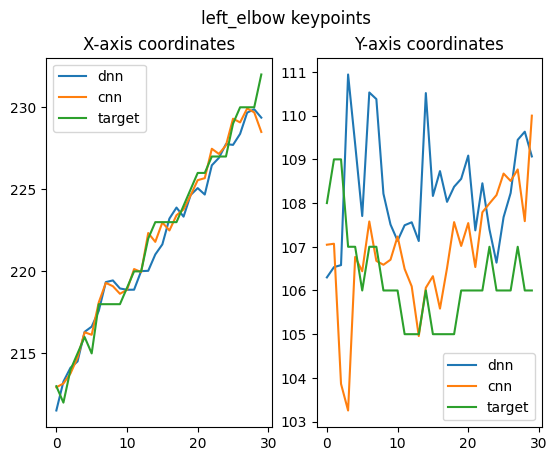

In [23]:
index = np.random.randint(0, X.shape[0])
keypoint_index = np.random.randint(0, 5) # 0-4
keypoint_name = keypoint_names[keypoints_to_detect[keypoint_index]]
y = cnn_model.predict(X[index:index+1])
y1 = dnn_model.predict(X[index:index+1])
# make 2 graphs 1 for x-axis coordinates and another for y-axis coordinates
plt.subplot(1, 2, 1)
# plt.plot(X[index, keypoint_index, :30, 0], 'o', markersize=1)
plt.plot(y1[0, keypoint_index, :, 0], '-', markersize=1)
plt.plot(y[0, keypoint_index, :, 0], '-', markersize=1)
plt.plot(Y[index, keypoint_index, :, 0], '-', markersize=1)
plt.legend(['dnn', 'cnn', 'target'])
plt.title('X-axis coordinates')
# plt.axis([0,30,130,170])
plt.subplot(1, 2, 2)
# plt.plot(X[index, keypoint_index, :30, 1], '-', markersize=1)
plt.plot(y1[0, keypoint_index, :, 1], '-', markersize=1)
plt.plot(y[0, keypoint_index, :, 1], '-', markersize=1)
plt.plot(Y[index, keypoint_index, :, 1], '-', markersize=1)
plt.legend(['dnn', 'cnn', 'target'])
plt.title('Y-axis coordinates')
# plt.axis([0,30,130,170])
plt.suptitle(f'{keypoint_name} keypoints')




In [12]:
dnn_out = dnn_model.predict(X)
cnn_out = cnn_model.predict(X)

3603/3603 [==============================] - 23s 6ms/step


MAE DNN: 0.8495390163204112
MAE CNN: 0.751131307444039
MSE DNN: 5.106019681359733
MSE CNN: 2.2202660756511188
MAPE DNN: 0.01825325257608697
MAPE CNN: 0.01394669719243087


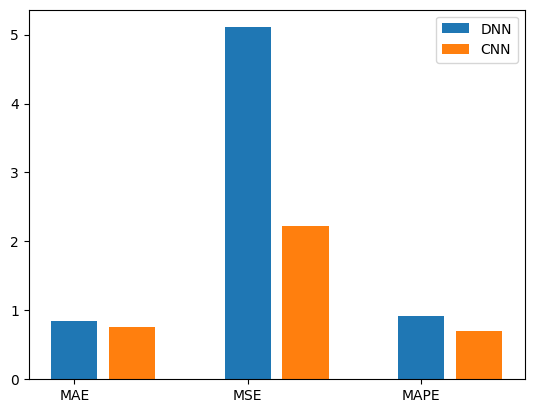

In [13]:
mae_dnn = np.mean(np.abs(dnn_out - Y))
mae_cnn = np.mean(np.abs(cnn_out - Y))

mse_dnn = np.mean((dnn_out - Y)**2)
mse_cnn = np.mean((cnn_out - Y)**2)

mape_dnn = np.mean(np.abs(dnn_out - Y) / (Y + 0.1))
mape_cnn = np.mean(np.abs(cnn_out - Y) / (Y + 0.1))

print(f'MAE DNN: {mae_dnn}')
print(f'MAE CNN: {mae_cnn}')
print(f'MSE DNN: {mse_dnn}')
print(f'MSE CNN: {mse_cnn}')
print(f'MAPE DNN: {mape_dnn}')
print(f'MAPE CNN: {mape_cnn}')

# side by side comparison of DNN and CNN scores as bar graph
mape_cnn *= 50
mape_dnn *= 50
x_pos = np.arange(9, step=3)
plt.bar(x_pos, [mae_dnn, mse_dnn, mape_dnn])
plt.bar(x_pos+1, [mae_cnn, mse_cnn, mape_cnn])
plt.xticks(x_pos, ['MAE', 'MSE', 'MAPE'])
plt.legend(['DNN', 'CNN'])